# SVM

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('..\\data\\data.csv')

model = SVC(kernel='linear', random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)



# Definisco features
features = ['wind_direction', 'U', 'concentration', 'q']
# Definisco target
target = 'distance'

X = df[features]
y = df[target]

# Informazioni sui dati
print("Shape of the dataset:", df.shape)
print("Classi target:", sorted(y.unique()))
print('Distribution of target classes:', y.value_counts().sort_index())





Shape of the dataset: (2836, 7)
Classi target: [np.int64(50), np.int64(100), np.int64(200)]
Distribution of target classes: distance
50     1081
100     963
200     792
Name: count, dtype: int64


In [16]:
# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dei dati
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Cross-validation
scores = cross_val_score(model, X_train, y_train, cv=kf)
print("Cross-validation scores:", scores)



Cross-validation scores: [0.530837   0.55286344 0.54405286 0.52317881 0.54083885]


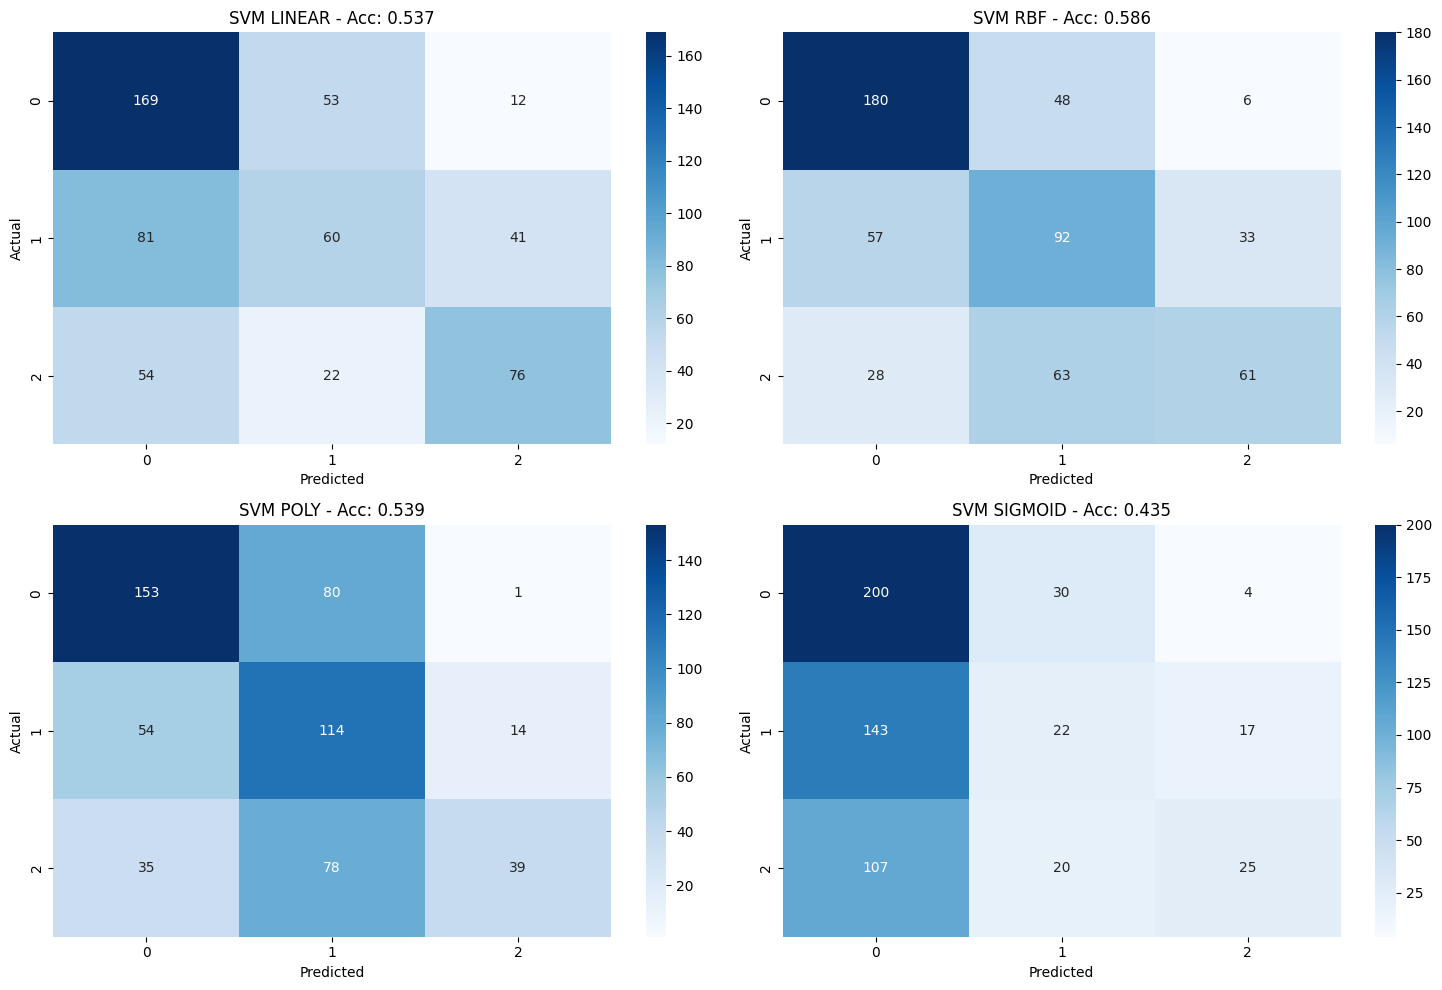

=== CONFRONTO KERNEL SVM ===
LINEAR:
  CV Accuracy: 0.5384 ± 0.0052
  Test Accuracy: 0.5370

RBF:
  CV Accuracy: 0.5935 ± 0.0092
  Test Accuracy: 0.5863

POLY:
  CV Accuracy: 0.5295 ± 0.0196
  Test Accuracy: 0.5387

SIGMOID:
  CV Accuracy: 0.4083 ± 0.0144
  Test Accuracy: 0.4349



In [17]:
# Confronto di diversi kernel SVM
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
svm_results = {}

plt.figure(figsize=(15, 10))

for i, kernel in enumerate(kernels):
    # Modello con kernel specifico
    svm = SVC(kernel=kernel, random_state=42, probability=True)
    
    # Cross-validation
    new_var = svm
    cv_scores = cross_val_score(new_var, X_train, y_train, cv=5, scoring='accuracy')
    
    # Fit e test
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    svm_results[kernel] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy,
        'model': svm
    }
    
    # Confusion matrix
    plt.subplot(2, 2, i+1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'SVM {kernel.upper()} - Acc: {test_accuracy:.3f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Riepilogo risultati
print("=== CONFRONTO KERNEL SVM ===")
for kernel, results in svm_results.items():
    print(f"{kernel.upper()}:")
    print(f"  CV Accuracy: {results['cv_mean']:.4f} ± {results['cv_std']:.4f}")
    print(f"  Test Accuracy: {results['test_accuracy']:.4f}")
    print()

In [18]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(), param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
print("=== GRID SEARCH RESULTS ===")
print("Best parameters found:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)


=== GRID SEARCH RESULTS ===
Best parameters found: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.7217969289416616


In [19]:

best_params = grid.best_params_
final_model = SVC(**best_params, probability=True, random_state=42, class_weight='balanced')
final_model.fit(X_train, y_train)


y_pred = final_model.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

          50       0.81      0.74      0.77       234
         100       0.57      0.62      0.59       182
         200       0.72      0.74      0.73       152

    accuracy                           0.70       568
   macro avg       0.70      0.70      0.70       568
weighted avg       0.71      0.70      0.70       568

Confusion matrix:
 [[173  54   7]
 [ 32 112  38]
 [  9  30 113]]


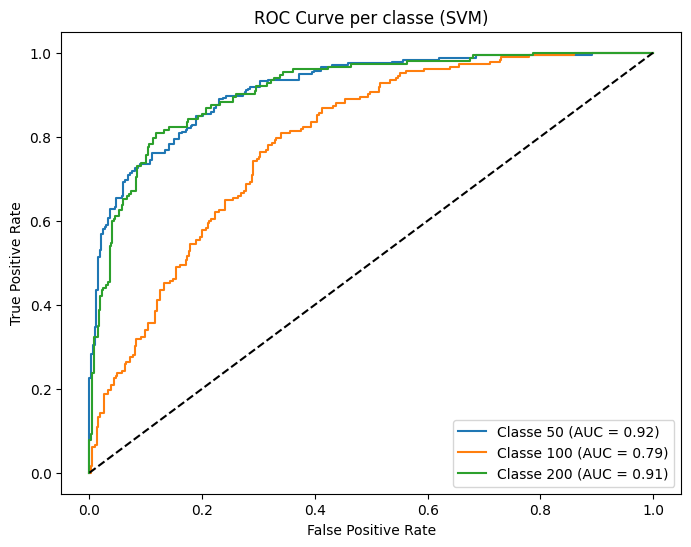

In [20]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = final_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(fpr, tpr, label=f'Classe {class_label} (AUC = {auc(fpr, tpr):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per classe (SVM)')
plt.legend()
plt.show()

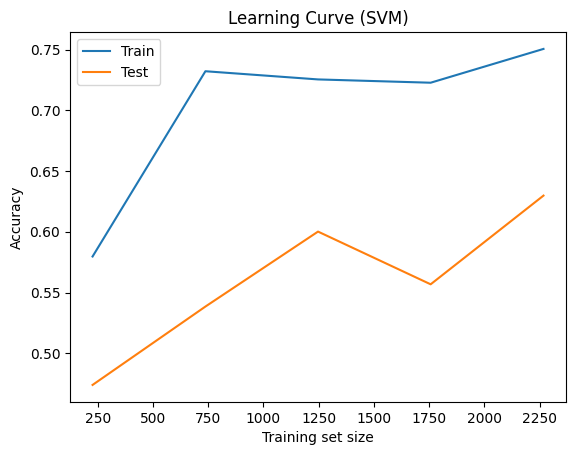

In [21]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(final_model, X_scaled, y, cv=5)
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curve (SVM)')
plt.legend()
plt.show()

In [22]:
import joblib
# salvo il modello
joblib.dump(final_model, 'svm_model.pkl')

['svm_model.pkl']

## Conclusioni

Dal report si evince che il modello ha un problema di classificazione per distanze di 100 e 200 metri.
Il problema potrebbe essere:
- Feature poco discriminanti -> wind_direction, U e concentration non sono sufficientemente diverse tra le classi 100 e 200.

La classe 50 é ben separata dalle altre e quindi il modello la riconosce abbastanza bene, le altre potrebbero essere "mischiate" come si evince dalla matrice di confusione